##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Copulas Primer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>




In [0]:
!pip install -q tensorflow-probability

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

A [copula](https://en.wikipedia.org/wiki/Copula_(probability_theory%29) is a classical approach for capturing the dependence between random variables. More formally, a copula is a multivariate distribution $C(U_1, U_2, ...., U_n)$ such that marginalizing gives $U_i \sim \text{Uniform}(0, 1)$.


Copulas are interesting because we can use them to create multivariate distributions with arbitrary marginals. This is the recipe:

* Using the [Probability Integral Transform](https://en.wikipedia.org/wiki/Probability_integral_transform) turns an arbitrary continuous R.V. $X$ into a uniform one $F_X(X)$, where $F_X$ is the CDF of $X$.
* Given a copula (say bivariate) $C(U, V)$, we have that $U$ and $V$ have uniform marginal distributions.
* Now given our R.V's of interest $X, Y$, create a new distribution $C'(X, Y) = C(F_X(X), F_Y(Y))$. The marginals for $X$ and $Y$ are the ones we desired.

Marginals are univariate and thus may be easier to measure and/or model. A copula enables starting from marginals yet also achieving arbitrary correlation between dimensions.


# Gaussian Copula

To illustrate how copulas are constructed, consider the case of capturing dependence according to multivariate Gaussian correlations. A Gaussian Copula is one given by $C(u_1, u_2, ...u_n) = \Phi_\Sigma(\Phi^{-1}(u_1), \Phi^{-1}(u_2), ... \Phi^{-1}(u_n))$  where $\Phi_\Sigma$ represents the CDF of a MultivariateNormal, with covariance $\Sigma$ and mean 0, and $\Phi^{-1}$ is the inverse CDF for the standard normal.


Applying the normal's inverse CDF warps the uniform dimensions to be normally distributed. Applying the multivariate normal's CDF then squashes the distribution to be marginally uniform and with Gaussian correlations.

Thus, what we get is that the Gaussian Copula is a distribution over the unit hypercube $[0, 1]^n$ with uniform marginals.

Defined as such, the Gaussian Copula can be implemented with `tfd.TransformedDistribution` and appropriate `Bijector`. That is, we are transforming a MultivariateNormal, via the use of the Normal distribution's inverse CDF. A `Bijector` modelling this is listed below.

In [0]:
class NormalCDF(tfb.Bijector):
  """Bijector that encodes normal CDF and inverse CDF functions.
  
  We follow the convention that the `inverse` represents the CDF
  and `forward` the inverse CDF (the reason for this convention is
  that inverse CDF methods for sampling are expressed a little more
  tersely this way).
  
  """
  def __init__(self):
    self.normal_dist = tfd.Normal(loc=0., scale=1.)
    super(NormalCDF, self).__init__(
        forward_min_event_ndims=0,
        validate_args=False,
        name="NormalCDF")
    
  def _forward(self, y):
    # Inverse CDF of normal distribution.
    return self.normal_dist.quantile(y)
  
  def _inverse(self, x):
    # CDF of normal distribution. 
    return self.normal_dist.cdf(x)
  
  def _inverse_log_det_jacobian(self, x):
    # Log PDF of the normal distribution.
    return self.normal_dist.log_prob(x)

Below, we implement a Gaussian Copula with one simplifying assumption: that the covariance is parameterized
by a Cholesky factor (hence a covariance for `MultivariateNormalTriL`). (One could use other `tf.linalg.LinearOperators` to encode different matrix free assumptions.).

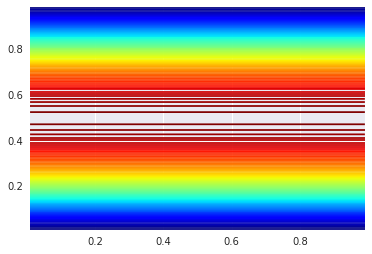

In [0]:
class GaussianCopulaTriL(tfd.TransformedDistribution):
  """Takes a location, and lower triangular matrix for the Cholesky factor."""
  def __init__(self, loc, scale_tril):
    super(GaussianCopulaTriL, self).__init__(
        distribution=tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale_tril),
        bijector=tfb.Invert(NormalCDF()),
        validate_args=False,
        name="GaussianCopulaTriLUniform")
    

# Plot an example of this.
unit_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(unit_interval, unit_interval)
coordinates = np.concatenate(
    [x_grid[..., np.newaxis],
     y_grid[..., np.newaxis]], axis=-1)

pdf = GaussianCopulaTriL(
    loc=[0., 0.],
    scale_tril=[[1., 0.8], [0., 0.6]],
).prob(coordinates)

# Plot its density.
with tf.Session() as sess:
  pdf_eval = sess.run(pdf)
plt.contour(x_grid, y_grid, pdf_eval, 100, cmap=plt.cm.jet);

The power, however, from such a model is using the Probability Integral Transform, to use the copula on arbitrary R.V.s. In this way, we can specify arbitrary marginals, and use the copula to stitch them together.

We start with a model:

$$\begin{align*}
X &\sim \text{Kumaraswamy}(a, b) \\
Y &\sim \text{Gumbel}(\mu, \beta)
\end{align*}$$

and use the copula to get a bivariate R.V. $Z$, which has marginals [Kumaraswamy](https://en.wikipedia.org/wiki/Kumaraswamy_distribution) and [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution).


We'll start by plotting the product distribution generated by those two R.V.s. This is just to serve as a comparison point to when we apply the Copula.

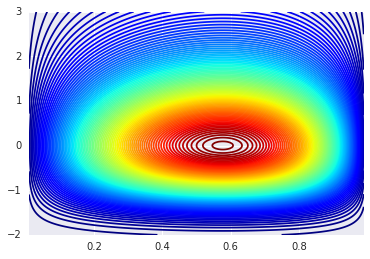

In [3]:
a = 2.0
b = 2.0
gloc = 0.
gscale = 1.

x = tfd.Kumaraswamy(a, b)
y = tfd.Gumbel(loc=gloc, scale=gscale)

# Plot the distributions, assuming independence
x_axis_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
y_axis_interval = np.linspace(-2., 3., num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(x_axis_interval, y_axis_interval)

pdf = x.prob(x_grid) * y.prob(y_grid)

# Plot its density
with tf.Session() as sess:
  pdf_eval = sess.run(pdf)

plt.contour(x_grid, y_grid, pdf_eval, 100, cmap=plt.cm.jet);

Now we use a Gaussian copula to couple the distributions together, and plot that. Again our tool of choice is `TransformedDistribution` applying the appropriate `Bijector`.

Specifically, we define a `Concat` bijector which applies different bijectors at different parts of the vector (which is still a bijective transformation).

In [0]:
class Concat(tfb.Bijector):
  """This bijector concatenates bijectors who act on scalars.
  
  More specifically, given [F_0, F_1, ... F_n] which are scalar transformations,
  this bijector creates a transformation which operates on the vector 
  [x_0, ... x_n] with the transformation [F_0(x_0), F_1(x_1) ..., F_n(x_n)].
  
  
  NOTE: This class does no error checking, so use with caution.
  
  """
  def __init__(self, bijectors):
    self._bijectors = bijectors
    super(Concat, self).__init__(
        forward_min_event_ndims=1,
        validate_args=False,
        name="ConcatBijector")
    
  @property
  def bijectors(self):
    return self._bijectors
    
  def _forward(self, x):
    split_xs = tf.split(x, len(self.bijectors), -1)
    transformed_xs = [b_i.forward(x_i) for b_i, x_i in zip(
        self.bijectors, split_xs)]
    return tf.concat(transformed_xs, -1)
  
  def _inverse(self, y):
    split_ys = tf.split(y, len(self.bijectors), -1)
    transformed_ys = [b_i.inverse(y_i) for b_i, y_i in zip(
        self.bijectors, split_ys)]
    return tf.concat(transformed_ys, -1)
  
  def _forward_log_det_jacobian(self, x):
    split_xs = tf.split(x, len(self.bijectors), -1)
    fldjs = [
        b_i.forward_log_det_jacobian(x_i, event_ndims=0) for b_i, x_i in zip(
            self.bijectors, split_xs)]
    return tf.squeeze(sum(fldjs), axis=-1)
  
  def _inverse_log_det_jacobian(self, y):
    split_ys = tf.split(y, len(self.bijectors), -1)
    ildjs = [
        b_i.inverse_log_det_jacobian(y_i, event_ndims=0) for b_i, y_i in zip(
            self.bijectors, split_ys)]
    return tf.squeeze(sum(ildjs), axis=-1)

Now we can define the Copula we want. Given a list of target marginals (encoded as bijectors), we can easily construct
a new distribution that uses the copula and has the specified marginals.

Note that $C'(X, Y) = C(F_X(X), F_Y(Y))$. This is mathematically equivalent to using `Concat([F_X, F_Y])`.


In [0]:
class WarpedGaussianCopula(tfd.TransformedDistribution):
  """Application of a Gaussian Copula on a list of target marginals.
  
  This implements an application of a Gaussian Copula. Given [x_0, ... x_n]
  which are distributed marginally (with CDF) [F_0, ... F_n],
  `GaussianCopula` represents an application of the Copula, such that the
  resulting multivariate distribution has the above specified marginals.
  
  The marginals are specified by `marginal_bijectors`: These are
  bijectors whose `inverse` encodes the CDF and `forward` the inverse CDF.
  """
  def __init__(self, loc, scale_tril, marginal_bijectors):
    super(WarpedGaussianCopula, self).__init__(
        distribution=GaussianCopulaTriL(loc=loc, scale_tril=scale_tril),
        bijector=Concat(marginal_bijectors),
        validate_args=False,
        name="GaussianCopula")
    
  @property
  def marginal_bijectors(self):
    """List of bijectors which correspond to marginals."""

Finally, let's actually use this Gaussian Copula. We'll use a Cholesky of $\begin{bmatrix}1 & 0\\\rho & \sqrt{(1-\rho^2)}\end{bmatrix}$, which will correspond to variances 1, and correlation $\rho$ for the multivariate normal.


We'll look at a few cases: 

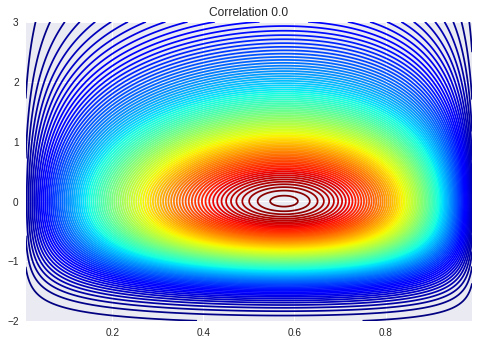

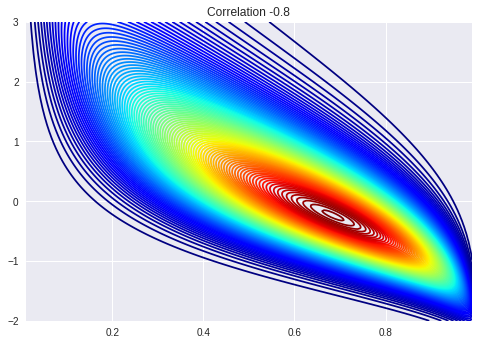

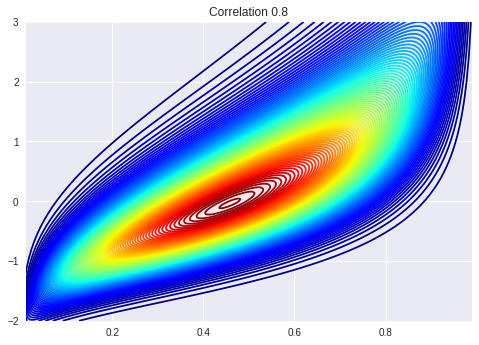

In [0]:
# Create our coordinates:
coordinates = np.concatenate(
    [x_grid[..., np.newaxis], y_grid[..., np.newaxis]], -1)


def create_gaussian_copula(correlation): 
  # Use Gaussian Copula to add dependence.
  return WarpedGaussianCopula(
      loc=[0.,  0.], 
      scale_tril=[[1., 0.], [correlation, tf.sqrt(1. - correlation ** 2)]],
      # These encode the marginals we want. In this case we want X_0 has 
      # Kumaraswamy marginal, and X_1 has Gumbel marginal.
      
      marginal_bijectors=[
          tfb.Kumaraswamy(a, b), 
          # Kumaraswamy follows the above convention, while
          # Gumbel does not, and has to be inverted.
          tfb.Invert(tfb.Gumbel(loc=0., scale=1.))])


# Note that the zero case will correspond to independent marginals!
correlations = [0., -0.8, 0.8]
copulas = []
probs = []
for correlation in correlations:
  copula = create_gaussian_copula(correlation)
  copulas.append(copula)
  probs.append(copula.prob(coordinates))
  

# Plot it's density
with tf.Session() as sess:
  copula_evals = sess.run(probs)

for correlation, copula_eval in zip(correlations, copula_evals):
  plt.contour(x_grid, y_grid, copula_eval, 100, cmap=plt.cm.jet);
  plt.title('Correlation {}'.format(correlation));
  plt.figure();


Finally, let's verify that we actually get the marginals we want.

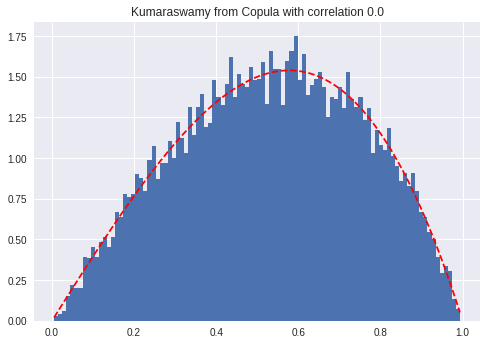

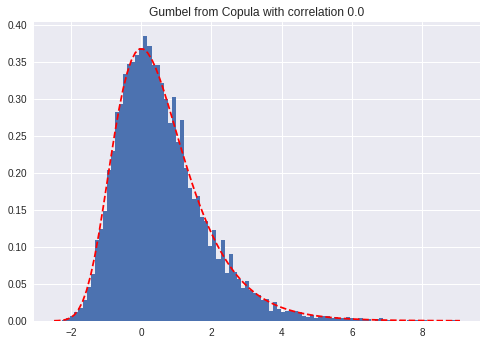

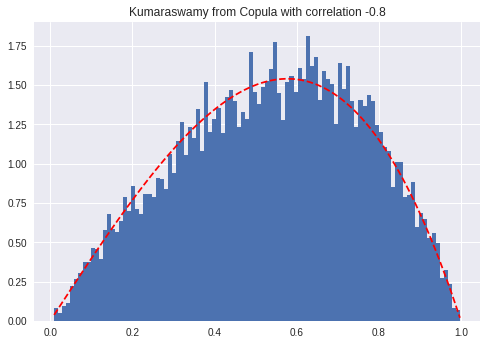

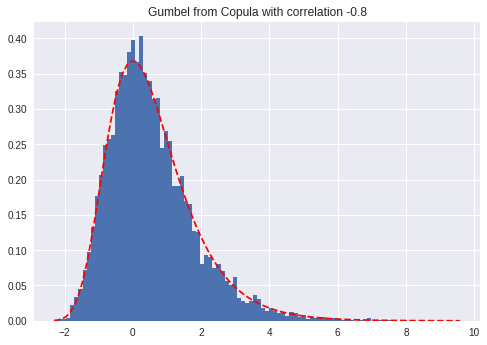

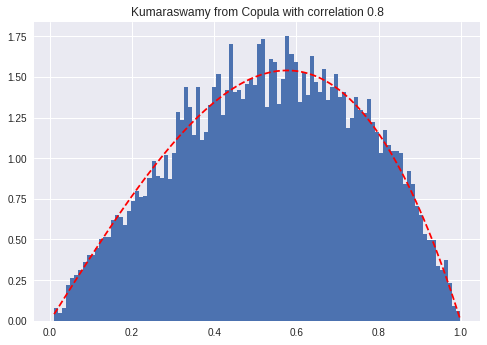

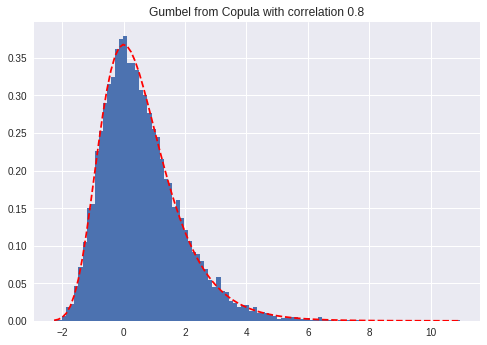

In [0]:
def kumaraswamy_pdf(x):
  return tfd.Kumaraswamy(a, b).prob(np.float32(x)).eval()

def gumbel_pdf(x):
  return tfd.Gumbel(gloc, gscale).prob(np.float32(x)).eval()


samples = []
for copula in copulas:
  samples.append(copula.sample(10000))
  
with tf.Session() as sess:
  copula_evals = sess.run(samples)
  
  # Let's marginalize out on each, and plot the samples.

  for correlation, copula_eval in zip(correlations, copula_evals):
    k = copula_eval[..., 0]
    g = copula_eval[..., 1]
    _, bins, _ = plt.hist(k, bins=100, normed=True);
    plt.plot(bins, kumaraswamy_pdf(bins), 'r--');
    plt.title('Kumaraswamy from Copula with correlation {}'.format(correlation));
    plt.figure();
    _, bins, _ = plt.hist(g, bins=100, normed=True);
    plt.plot(bins, gumbel_pdf(bins), 'r--')
    plt.title('Gumbel from Copula with correlation {}'.format(correlation));
    plt.figure();

  

# Conclusion
And there we go! We've demonstrated that we can construct Gaussian Copulas using the `Bijector` API.

More generally, writing bijectors using the `Bijector` API and composing them with a distribution, can create rich families of distributions for flexible modelling.